# Dataset Information and Creation

This python notebook allow to better understand the dataset 'ECO', looking at what data is available, and then creating a new dataset that can be used to train a NILM model

## Imports

In [1]:
import numpy as np
from datetime import timedelta
from itertools import groupby
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from config_loader import load_config

In [2]:
config, config_dir = load_config()

env = config['Settings']['environment']
dataset_path = config['ML']['path']
data_path = config[env]['data_path']
training_dataset_file = config['Data']['training_dataset_file']
appliances_file = config['Data']['appliances_file']

## Appliances and Power Metrics

In [3]:
# List of appliances per household
appliances_list_1 = ['Fridge', 'Dryer', 'Coffee Machine', 'Kettle', 'Washing Machine', 'PC', 'Freezer']
appliances_list_2 = ['Tablet', 'Dishwasher', 'Air Exhaust', 'Fridge', 'Entertainment', 'Freezer', 'Kettle', 'Lamp', 'Laptops', 'Stove', 'TV', 'Stereo']
appliances_list_3 = ['Tablet', 'Freezer', 'Coffee Machine', 'PC', 'Fridge', 'Kettle', 'Entertainment']
appliances_list_4 = ['Fridge', 'Kitchen Appliances', 'Lamp', 'Stereo and Laptop', 'Freezer', 'Tablet', 'Entertainment', 'Microwave']
appliances_list_5 = ['Tablet', 'Coffee Machine', 'Fountain', 'Microwave', 'Fridge', 'Entertainment', 'PC', 'Kettle']
appliances_list_6 = ['Lamp', 'Laptop', 'Router', 'Coffee Machine', 'Entertainment', 'Fridge', 'Kettle']

# Power metrics that are available
powers_list = [
    'powerallphases', 'powerl1', 'powerl2', 'powerl3',
    'currentneutral', 'currentl1', 'currentl2', 'currentl3',
    'voltagel1', 'voltagel2', 'voltagel3',
    'phaseanglevoltagel2l1', 'phaseanglevoltagel3l1',
    'phaseanglecurrentvoltagel1', 'phaseanglecurrentvoltagel2', 'phaseanglecurrentvoltagel3'
]

# Power metrics that are not used, not available through the smart meter
powers_list_drop = ['powerallphases', 'currentneutral', 'phaseanglevoltagel2l1', 'phaseanglevoltagel3l1', 'phaseanglecurrentvoltagel1', 'phaseanglecurrentvoltagel2', 'phaseanglecurrentvoltagel3']

## Finding Common Date Ranges Across Folders

This function identifies all dates that are shared across multiple folders, assuming each folder contains
files named by date (in `YYYY-MM-DD` format). It then groups consecutive common dates into continuous
ranges for easier analysis. This is useful when working with time series data distributed across different
sources or categories, where only overlapping time periods are relevant.



In [4]:
def intersection_dates(ids, subfolder_list):
    # This will store one set of dates per folder
    all_date_sets = []

    for folder in subfolder_list:
        folder_path = os.path.join(ids, folder)
        files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

        # Extract date from filenames
        file_dates = [pd.to_datetime(file.split('.')[0], format='%Y-%m-%d') for file in files]
        file_dates_set = set(file_dates)

        print(f"{folder} has {len(file_dates_set)} dates.")
        all_date_sets.append(file_dates_set)

    # Now find the common dates across all folders
    common_dates = set.intersection(*all_date_sets)
    common_dates = sorted(common_dates)

    # Group consecutive dates into ranges
    date_ranges = []
    if not common_dates:
        print("No common dates found across all folders.")
        return

    start_date = common_dates[0]
    for i in range(1, len(common_dates)):
        # If the next date is not the next day, store the current range
        if common_dates[i] != common_dates[i-1] + pd.Timedelta(days=1):
            end_date = common_dates[i-1]
            date_ranges.append((start_date, end_date))
            start_date = common_dates[i]

    # Add the last range
    date_ranges.append((start_date, common_dates[-1]))

    # Print the date ranges
    print(f"\nCommon date ranges across all folders: {len(date_ranges)}")
    for start, end in date_ranges:
        print(f"From {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}")

    return date_ranges

## Checking Data Quality for a Single Day

This function checks whether a specific day's data for a given household is considered "clean" across a list
of appliances. It looks for long sequences of missing or invalid data (represented by `-1` values) in each
appliance's daily CSV file. If any such sequence exceeds a defined threshold (default: 30 samples), the day
is flagged as unclean and excluded from further analysis.

This helps ensure data reliability before performing time series analysis or machine learning tasks.


In [5]:
def is_day_clean(date, household_id, appliances_list, appliance_ids, threshold=30):
    for appliance, appliance_id in zip(appliances_list, appliance_ids):
        folder_path = os.path.join(dataset_path, household_id, appliance_id)
        file_name = f"{date.strftime('%Y-%m-%d')}.csv"
        file_path = os.path.join(folder_path, file_name)

        if not os.path.exists(file_path):
            continue

        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue

        for col in df.columns:
            if col.lower() in ['timestamp', 'time']:  # skip time column if present
                continue

            values = df[col].values
            for k, g in groupby(values):
                if k == -1 and len(list(g)) > threshold:
                    print(f"Long -1 sequence in {file_name} ({appliance}) — removing this day")
                    return False

    return True


## Filtering for Clean Date Ranges

This function refines a list of candidate date ranges by checking each day individually for data quality
(using the `is_day_clean` function). Only days that pass the quality check are retained. It then reconstructs
new, continuous date ranges made up exclusively of clean days.

This step ensures that subsequent analyses are based only on reliable, uninterrupted data, and also
highlights the longest stretch of clean data available for the household.


In [6]:
def clean_dates(dates, household_id, appliances_list, appliance_ids):
    if not dates:
        print("No valid dates found.")
        return
    # Step 1: Collect all valid dates
    clean_days = []

    for start_date, end_date in dates:
        current_day = start_date
        while current_day <= end_date:
            if is_day_clean(current_day, household_id, appliances_list, appliance_ids):
                clean_days.append(current_day)
            current_day += timedelta(days=1)

    # Step 2: Rebuild clean date ranges
    clean_days.sort()
    clean_ranges = []
    if clean_days:
        range_start = clean_days[0]
        range_end = clean_days[0]

        for i in range(1, len(clean_days)):
            if clean_days[i] == range_end + timedelta(days=1):
                range_end = clean_days[i]
            else:
                clean_ranges.append((range_start, range_end))
                range_start = clean_days[i]
                range_end = clean_days[i]
        clean_ranges.append((range_start, range_end))

    # Step 3: Print the clean ranges
    print("\nClean date ranges:")
    for start, end in clean_ranges:
        print(f"{start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}")

    if not clean_ranges:
        print("No clean ranges found.")
        return

    # Show the longest clean range
    longest_range = max(clean_ranges, key=lambda x: (x[1] - x[0]).days)
    print(f"Longest clean range: {longest_range[0].strftime('%Y-%m-%d')} to {longest_range[1].strftime('%Y-%m-%d')}")

    print(f"\nHousehold {household_id}: {len(clean_days)} clean days.")

    return clean_ranges

## Interpolating Missing Values in a Day

This function handles short sequences of missing values (represented by `-1`) in a day's data by interpolating
them, using a specified method (default: linear). It temporarily treats `-1` values as missing (`NaN`), performs
interpolation within a defined gap limit (default: 30), and restores the original structure for values that
could not be filled.

This is useful for preserving time series continuity while avoiding overfitting or distortion from long gaps.


In [7]:
def interpolate_day_from_minus1(df, method='linear', limit=30):
    # Only replace -1s temporarily for interpolation
    mask = (df == -1)

    # Convert -1 to a temporary NaN for interpolation
    df_interp = df.mask(mask)

    # Interpolate along columns (time-based axis), limited to small gaps
    df_interp = df_interp.interpolate(method=method, axis=0, limit=limit, limit_direction='both')

    # Restore the structure: if interpolation didn’t fix some -1s, put them back
    df_filled = df.where(~mask, df_interp)

    return df_filled


## Saving and Resampling Cleaned Appliance Data

This function loads and processes daily data for a given household across multiple appliances and a specified
date range. For each valid day:

- It reads the corresponding CSV files (one per appliance),
- Interpolates missing values (`-1`) using `interpolate_day_from_minus1`,
- Merges all appliance data into a single DataFrame,
- Resamples the data to 10-second intervals for uniformity,
- Optionally saves the cleaned dataset to a `.parquet` file.

The result is a time-aligned, cleaned, and resampled dataset suitable for further analysis or modeling.


In [8]:
def save_data(column_names, date_range, house_id, apps_id, sm_columns, save_to_file=False):
    all_data = []  # List of daily DataFrames to concat at the end

    if date_range is None:
        print("No valid dates found.")
        return

    for start_date, end_date in date_range:
        current_day = start_date
        while current_day <= end_date:
            day_data = pd.DataFrame()  # New DataFrame for one day

            for appliance, appliance_id in zip(column_names, apps_id):
                folder_path = f'{dataset_path}/{house_id}/{appliance_id}'
                file_name = f"{current_day.strftime('%Y-%m-%d')}.csv"
                file_path = os.path.join(folder_path, file_name)

                if not os.path.exists(file_path):
                    print(f"File not found: {file_path}")
                    continue

                try:
                    read_df = pd.read_csv(file_path, header=None)

                    if len(read_df) == 86400:
                        # interpolate missing values
                        read_df = interpolate_day_from_minus1(read_df)

                        if appliance_id == "sm":
                            # Handle multiple columns for smart meter
                            if read_df.shape[1] != len(sm_columns):
                                print(f"Warning: smart meter columns mismatch in {file_path} — expected {len(sm_columns)}, got {read_df.shape[1]}")
                                continue

                            read_df.columns = sm_columns
                            for col in sm_columns:
                                day_data[col] = read_df[col].values
                        else:
                            # Single-column appliance
                            if appliance != 'Smart Meter':
                                day_data[appliance] = read_df[0].values
                            else:
                                print('Appliance is smart meter')
                    else:
                        print(f"Skipping {file_path}: expected 86400 rows, got {len(read_df)}")

                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

            if not day_data.empty:
                # Generate timestamp column and insert as first column
                timestamps = pd.date_range(
                    start=current_day, periods=86400, freq='s'
                )
                day_data.insert(0, 'timestamp', timestamps)
                day_data.insert(1, 'household_id', house_id)

                # Resample the data every 10s
                # Ensure timestamp is set as index for resampling
                day_data.set_index('timestamp', inplace=True)
                # Select only numeric columns
                numeric_columns = day_data.select_dtypes(include=[np.number]).columns
                day_data_numeric = day_data[numeric_columns]
                # Resample every 10 seconds, taking the mean
                day_data_resampled = day_data_numeric.resample('10s').mean().interpolate(method='linear')
                # Restore the timestamp column and reset index
                day_data_resampled.reset_index(inplace=True)
                # Add household_id back
                day_data_resampled['household_id'] = house_id

                # Append to list
                all_data.append(day_data_resampled)

            current_day += pd.Timedelta(days=1)

    # Combine all days into one big DataFrame
    df = pd.concat(all_data, ignore_index=True)
    pd.set_option('display.max_columns', None)
    print(df.head())

    return df

## Household 1

In [9]:
household_id = "01"
# Define appliances and corresponding folder IDs
appliance_ids = [f'{i:02}' for i in range(1, len(appliances_list_1) + 1)]
appliance_ids.append('sm')
appliances_list_1.append("Smart Meter")

intersection_dates(os.path.join(dataset_path, household_id), appliance_ids)

print("\nRemoving appliance 06")
appliance_ids.remove('06')
appliances_list_1.remove('PC')
dates_1 = intersection_dates(os.path.join(dataset_path, household_id), appliance_ids)

print("\nCleaning dates")
clean_range_1 = clean_dates(dates_1, household_id, appliances_list_1, appliance_ids)

print("\nSaving data")
df_1 = save_data(appliances_list_1, clean_range_1, household_id, appliance_ids, powers_list)

01 has 231 dates.
02 has 231 dates.
03 has 113 dates.
04 has 203 dates.
05 has 231 dates.
06 has 66 dates.
07 has 231 dates.
sm has 245 dates.
No common dates found across all folders.

Removing appliance 06
01 has 231 dates.
02 has 231 dates.
03 has 113 dates.
04 has 203 dates.
05 has 231 dates.
07 has 231 dates.
sm has 245 dates.

Common date ranges across all folders: 7
From 2012-09-15 to 2012-10-16
From 2012-10-23 to 2012-11-16
From 2012-11-23 to 2012-11-27
From 2012-11-29 to 2012-11-30
From 2012-12-04 to 2012-12-09
From 2012-12-13 to 2012-12-16
From 2012-12-22 to 2013-01-23

Cleaning dates
Long -1 sequence in 2012-09-15.csv (Fridge) — removing this day
Long -1 sequence in 2012-09-21.csv (Fridge) — removing this day
Long -1 sequence in 2012-09-22.csv (Kettle) — removing this day
Long -1 sequence in 2012-09-25.csv (Fridge) — removing this day
Long -1 sequence in 2012-09-29.csv (Kettle) — removing this day
Long -1 sequence in 2012-09-30.csv (Kettle) — removing this day
Long -1 sequen

## Household 2

In [10]:
household_id = "02"
# Define appliances and corresponding folder IDs
appliance_ids = [f'{i:02}' for i in range(1, len(appliances_list_2) + 1)]
appliance_ids.append('sm')
appliances_list_2.append("Smart Meter")

intersection_dates(os.path.join(dataset_path, household_id), appliance_ids)

print()
print("Removing appliance 10")
appliance_ids.remove('10')
appliances_list_2.remove('Stove')
dates_2 = intersection_dates(os.path.join(dataset_path, household_id), appliance_ids)
print("\nCleaning dates")
clean_range_2 = clean_dates(dates_2, household_id, appliances_list_2, appliance_ids)

print("\nSaving data")
df_2 = save_data(appliances_list_2, clean_range_2, household_id, appliance_ids, powers_list)

01 has 240 dates.
02 has 240 dates.
03 has 240 dates.
04 has 240 dates.
05 has 236 dates.
06 has 240 dates.
07 has 240 dates.
08 has 240 dates.
09 has 240 dates.
10 has 28 dates.
11 has 240 dates.
12 has 240 dates.
sm has 244 dates.

Common date ranges across all folders: 10
From 2012-06-02 to 2012-06-07
From 2012-06-10 to 2012-06-13
From 2012-06-16 to 2012-06-18
From 2012-06-20 to 2012-06-20
From 2012-07-01 to 2012-07-01
From 2012-07-04 to 2012-07-05
From 2012-07-07 to 2012-07-08
From 2012-07-10 to 2012-07-11
From 2012-07-13 to 2012-07-17
From 2012-07-19 to 2012-07-20

Removing appliance 10
01 has 240 dates.
02 has 240 dates.
03 has 240 dates.
04 has 240 dates.
05 has 236 dates.
06 has 240 dates.
07 has 240 dates.
08 has 240 dates.
09 has 240 dates.
11 has 240 dates.
12 has 240 dates.
sm has 244 dates.

Common date ranges across all folders: 5
From 2012-06-01 to 2012-09-04
From 2012-09-08 to 2012-09-13
From 2012-09-15 to 2012-11-02
From 2012-11-07 to 2012-11-27
From 2012-11-29 to 2013

## Household 3

In [11]:
household_id = "03"
# Define appliances and corresponding folder IDs
appliance_ids = [f'{i:02}' for i in range(1, len(appliances_list_3) + 1)]
appliance_ids.append('sm')
appliances_list_3.append("Smart Meter")

dates_3 = intersection_dates(os.path.join(dataset_path, household_id), appliance_ids)
print("\nCleaning dates")
clean_range_3 = clean_dates(dates_3, household_id, appliances_list_3, appliance_ids)
print("\nSaving data")
df_3 = save_data(appliances_list_3, clean_range_3, household_id, appliance_ids, powers_list)

01 has 97 dates.
02 has 97 dates.
03 has 60 dates.
04 has 35 dates.
05 has 41 dates.
06 has 36 dates.
07 has 45 dates.
sm has 138 dates.

Common date ranges across all folders: 2
From 2012-12-06 to 2012-12-06
From 2012-12-30 to 2012-12-30

Cleaning dates
Long -1 sequence in 2012-12-06.csv (Tablet) — removing this day
Long -1 sequence in 2012-12-30.csv (Tablet) — removing this day

Clean date ranges:
No clean ranges found.

Saving data
No valid dates found.


## Household 4

In [12]:
household_id = "04"
# Define appliances and corresponding folder IDs
appliance_ids = [f'{i:02}' for i in range(1, len(appliances_list_4) + 1)]
appliance_ids.append('sm')
appliances_list_4.append("Smart Meter")

dates_4 = intersection_dates(os.path.join(dataset_path, household_id), appliance_ids)
print("\nCleaning dates")
clean_range_4 = clean_dates(dates_4, household_id, appliances_list_4, appliance_ids)
print("\nSaving data")
df_4 = save_data(appliances_list_4, clean_range_4, household_id, appliance_ids, powers_list)

01 has 194 dates.
02 has 194 dates.
03 has 170 dates.
04 has 169 dates.
05 has 192 dates.
06 has 189 dates.
07 has 186 dates.
08 has 195 dates.
sm has 219 dates.

Common date ranges across all folders: 7
From 2012-06-27 to 2012-07-14
From 2012-07-23 to 2012-09-05
From 2012-09-11 to 2012-10-20
From 2012-11-09 to 2012-11-10
From 2012-11-14 to 2012-11-16
From 2012-12-01 to 2012-12-22
From 2012-12-24 to 2013-01-13

Cleaning dates
Long -1 sequence in 2012-06-27.csv (Fridge) — removing this day
Long -1 sequence in 2012-06-28.csv (Fridge) — removing this day
Long -1 sequence in 2012-06-29.csv (Fridge) — removing this day
Long -1 sequence in 2012-07-01.csv (Smart Meter) — removing this day
Long -1 sequence in 2012-07-02.csv (Fridge) — removing this day
Long -1 sequence in 2012-07-03.csv (Fridge) — removing this day
Long -1 sequence in 2012-07-05.csv (Fridge) — removing this day
Long -1 sequence in 2012-07-06.csv (Fridge) — removing this day
Long -1 sequence in 2012-07-07.csv (Fridge) — removin

## Household 5

In [13]:
household_id = "05"
# Define appliances and corresponding folder IDs
appliance_ids = [f'{i:02}' for i in range(1, len(appliances_list_5) + 1)]
appliance_ids.append('sm')
appliances_list_5.append("Smart Meter")

intersection_dates(os.path.join(dataset_path, household_id), appliance_ids)

print()
print("Removing appliance 03")
print("Removing appliance 08")
appliance_ids.remove('03')
appliance_ids.remove('08')
appliances_list_5.remove('Fountain')
appliances_list_5.remove('Kettle')

dates_5 = intersection_dates(os.path.join(dataset_path, household_id), appliance_ids)
print("\nCleaning dates")
clean_range_5 = clean_dates(dates_5, household_id, appliances_list_5, appliance_ids)
print("\nSaving data")
df_5 = save_data(appliances_list_5, clean_range_5, household_id, appliance_ids, powers_list)

01 has 218 dates.
02 has 218 dates.
03 has 71 dates.
04 has 218 dates.
05 has 218 dates.
06 has 192 dates.
07 has 218 dates.
08 has 25 dates.
sm has 215 dates.
No common dates found across all folders.

Removing appliance 03
Removing appliance 08
01 has 218 dates.
02 has 218 dates.
04 has 218 dates.
05 has 218 dates.
06 has 192 dates.
07 has 218 dates.
sm has 215 dates.

Common date ranges across all folders: 6
From 2012-06-27 to 2012-08-10
From 2012-09-04 to 2012-09-06
From 2012-09-11 to 2012-10-15
From 2012-10-17 to 2012-11-27
From 2012-11-29 to 2012-12-20
From 2012-12-22 to 2013-01-31

Cleaning dates
Long -1 sequence in 2012-06-27.csv (Entertainment) — removing this day
Long -1 sequence in 2012-06-28.csv (Tablet) — removing this day
Long -1 sequence in 2012-06-29.csv (Tablet) — removing this day
Long -1 sequence in 2012-06-30.csv (Coffee Machine) — removing this day
Long -1 sequence in 2012-07-05.csv (Entertainment) — removing this day
Long -1 sequence in 2012-07-08.csv (Entertainme

## Household 6

In [14]:
household_id = "06"
# Define appliances and corresponding folder IDs
appliance_ids = [f'{i:02}' for i in range(1, len(appliances_list_6) + 1)]
appliance_ids.append('sm')
appliances_list_6.append("Smart Meter")

dates_6 = intersection_dates(os.path.join(dataset_path, household_id), appliance_ids)
print("\nCleaning dates")
clean_range_6 = clean_dates(dates_6, household_id, appliances_list_6, appliance_ids)
print("\nSaving data")
df_6 = save_data(appliances_list_6, clean_range_6, household_id, appliance_ids, powers_list)

01 has 166 dates.
02 has 185 dates.
03 has 88 dates.
04 has 179 dates.
05 has 181 dates.
06 has 179 dates.
07 has 147 dates.
sm has 166 dates.

Common date ranges across all folders: 4
From 2012-06-27 to 2012-08-25
From 2012-08-30 to 2012-08-30
From 2012-09-03 to 2012-09-08
From 2012-09-17 to 2012-09-22

Cleaning dates
Long -1 sequence in 2012-06-28.csv (Lamp) — removing this day
Long -1 sequence in 2012-06-29.csv (Lamp) — removing this day
Long -1 sequence in 2012-06-30.csv (Lamp) — removing this day
Long -1 sequence in 2012-07-01.csv (Lamp) — removing this day
Long -1 sequence in 2012-07-02.csv (Smart Meter) — removing this day
Long -1 sequence in 2012-07-07.csv (Lamp) — removing this day
Long -1 sequence in 2012-07-12.csv (Lamp) — removing this day
Long -1 sequence in 2012-07-13.csv (Lamp) — removing this day
Long -1 sequence in 2012-07-14.csv (Lamp) — removing this day
Long -1 sequence in 2012-07-15.csv (Lamp) — removing this day
Long -1 sequence in 2012-07-18.csv (Lamp) — removing

## Creating a single dataframe for all households

In [15]:
# Concatenate all DataFrames into one
dataframes = [df_1, df_4, df_5, df_6]
combined_df = pd.concat(dataframes, ignore_index=True)
print(combined_df.head())

# Combine appliance lists
all_appliances = appliances_list_1 + appliances_list_4 + appliances_list_5 + appliances_list_6
print(all_appliances)

# Remove duplicates and sort the list
unique_appliances = list(set(all_appliances))
unique_appliances.remove('Smart Meter')
unique_appliances = sorted(unique_appliances)
print(unique_appliances)

desired_order = ['timestamp', 'household_id'] + powers_list + unique_appliances

combined_df = combined_df[desired_order]

# Drop unnecessary columns
combined_df.drop(columns=powers_list_drop, inplace=True)

# Replace NaN values with 0 for missing appliance data
combined_df = combined_df.fillna(0)

            timestamp    Fridge  Dryer  Coffee Machine  Kettle  \
0 2012-09-16 00:00:00  1.323468    0.0             0.0     0.0   
1 2012-09-16 00:00:10  1.323468    0.0             0.0     0.0   
2 2012-09-16 00:00:20  0.882312    0.0             0.0     0.0   
3 2012-09-16 00:00:30  0.661734    0.0             0.0     0.0   
4 2012-09-16 00:00:40  1.323468    0.0             0.0     0.0   

   Washing Machine  Freezer  powerallphases  powerl1  powerl2  powerl3  \
0         0.226097  37.3928         88.3121  60.0575  18.2049  10.0497   
1         0.000000  37.3928         88.4071  60.0084  18.4098   9.9889   
2         0.226097  37.6085         88.2307  59.8883  18.3856   9.9568   
3         0.000000  37.3928         88.3118  59.9243  18.3527  10.0348   
4         0.226097  37.8242         88.0675  59.8486  18.2500   9.9689   

   currentneutral  currentl1  currentl2  currentl3  voltagel1  voltagel2  \
0         0.29844    0.45069    0.18567    0.12098    237.301      237.0   
1     

In [16]:
# Step 1: Create powerallphases by summing the three phases
combined_df['powerallphases'] = combined_df['powerl1'] + combined_df['powerl2'] + combined_df['powerl3']

# Step 2: Calculate total appliance consumption
combined_df['total_appliance_consumption'] = combined_df[unique_appliances].sum(axis=1)

# Step 3: Calculate 'Other' power
combined_df['Other'] = combined_df['powerallphases'] - combined_df['total_appliance_consumption']

# Step 4: Remove the helper column if you don’t need it
combined_df.drop(columns=['total_appliance_consumption'], inplace=True)
combined_df.drop(columns=['powerallphases'], inplace=True)

# Optional: Move 'Other' to the end of the dataframe
other_col = combined_df.pop('Other')
combined_df['Other'] = other_col
unique_appliances.append('Other')

combined_df['Other'] = combined_df['Other'].clip(lower=0)

## Final Checks and Appliance Balancing

This section performs quality control and balances the dataset before analysis:

- **Sanity Checks**: Verifies that no `-1` values or `NaN` entries remain in the combined DataFrame.
- **Appliance Activity Check**: Counts how often each appliance registers a non-zero value, giving a sense of usage balance across appliances.
- **Column Cleanup**: Allows for optional removal of unused or irrelevant appliance columns.
- **Appliance List Update**: Ensures that the list of active appliances matches the cleaned dataset.

This step ensures that the dataset is clean, consistent, and limited to meaningful appliances for analysis.


In [17]:
# check if -1 value is in df
print("Checking for -1 values in the DataFrame (should be 0):")
print((combined_df == -1).sum().sum())
# check if there are any missing values
print("Checking for missing values in the DataFrame (should be 0):")
print(combined_df.isnull().sum().sum())

# Find balance between appliances
appliance_counts = combined_df[unique_appliances].gt(0).sum()
print("Counts of appliances with non-zero values:")
print(appliance_counts)


# Calculate percentage of 0s for each appliance
zero_percentage = (combined_df[unique_appliances] == 0).sum() / len(combined_df) * 100

# Print the result
print("Percentage of 0s for each appliance:")
formatted_zero_percentage = zero_percentage.sort_values(ascending=False).apply(lambda x: f"{x:.2f}%")
print(formatted_zero_percentage)

# Drop useless appliances columns
remove_appliances = ['Kettle', 'Kitchen Appliances', 'Stereo and Laptop', 'Entertainment']
combined_df.drop(columns=remove_appliances, inplace=True)

print(combined_df.columns)

# Remove remove_appliances from unique_appliances
for appliance in remove_appliances:
    if appliance in unique_appliances:
        unique_appliances.remove(appliance)

print(unique_appliances)

# Save the appliances as a list in a file
path = os.path.join(data_path, appliances_file)
with open(path, 'w') as f:
    for appliance in unique_appliances:
        f.write(f"{appliance}\n")

print("Appliance names saved into file")

Checking for -1 values in the DataFrame (should be 0):
0
Checking for missing values in the DataFrame (should be 0):
0
Counts of appliances with non-zero values:
Coffee Machine          57502
Dryer                   80895
Entertainment          941768
Freezer                423282
Fridge                1148705
Kettle                   1417
Kitchen Appliances     121318
Lamp                   145282
Laptop                 198443
Microwave              760320
PC                     613440
Router                 198720
Stereo and Laptop      146880
Tablet                 757682
Washing Machine        135446
Other                 1234037
dtype: int64
Percentage of 0s for each appliance:
Kettle                99.885311
Coffee Machine        95.345927
Dryer                 93.452554
Kitchen Appliances    90.180815
Washing Machine       89.037328
Lamp                  88.241226
Stereo and Laptop     88.111888
Laptop                83.938504
Router                83.916084
Freezer             

## Appliance Zero-Value Analysis

This section computes the **percentage of zero values** for each appliance across all timestamps:

- Helps identify appliances with **little to no activity**.
- Useful for **filtering out inactive or irrelevant appliances** from the analysis.
- Percentages are sorted in descending order to highlight the least active appliances.

This metric supports informed decisions on which appliances may be excluded to reduce data noise or improve model focus.


In [18]:
# Count total entries per appliance
total_counts = combined_df[unique_appliances].shape[0]

# Count how many values are 0 for each appliance
zero_counts = (combined_df[unique_appliances] == 0).sum()

# Count how many values are negative for each appliance
negative_counts = (combined_df[unique_appliances] < 0).sum()

# Display nicely
print("Count of zeros:")
print(zero_counts.sort_values(ascending=False))

print("\nCount of negative values:")
print(negative_counts.sort_values(ascending=False))


Count of zeros:
Coffee Machine     1178018
Dryer              1154625
Washing Machine    1100074
Lamp               1090238
Laptop             1037077
Router             1036800
Freezer             812238
PC                  622080
Tablet              477838
Microwave           475200
Fridge               86815
Other                 1483
dtype: int64

Count of negative values:
Coffee Machine     0
Dryer              0
Freezer            0
Fridge             0
Lamp               0
Laptop             0
Microwave          0
PC                 0
Router             0
Tablet             0
Washing Machine    0
Other              0
dtype: int64


## Plotting the distribution of appliances

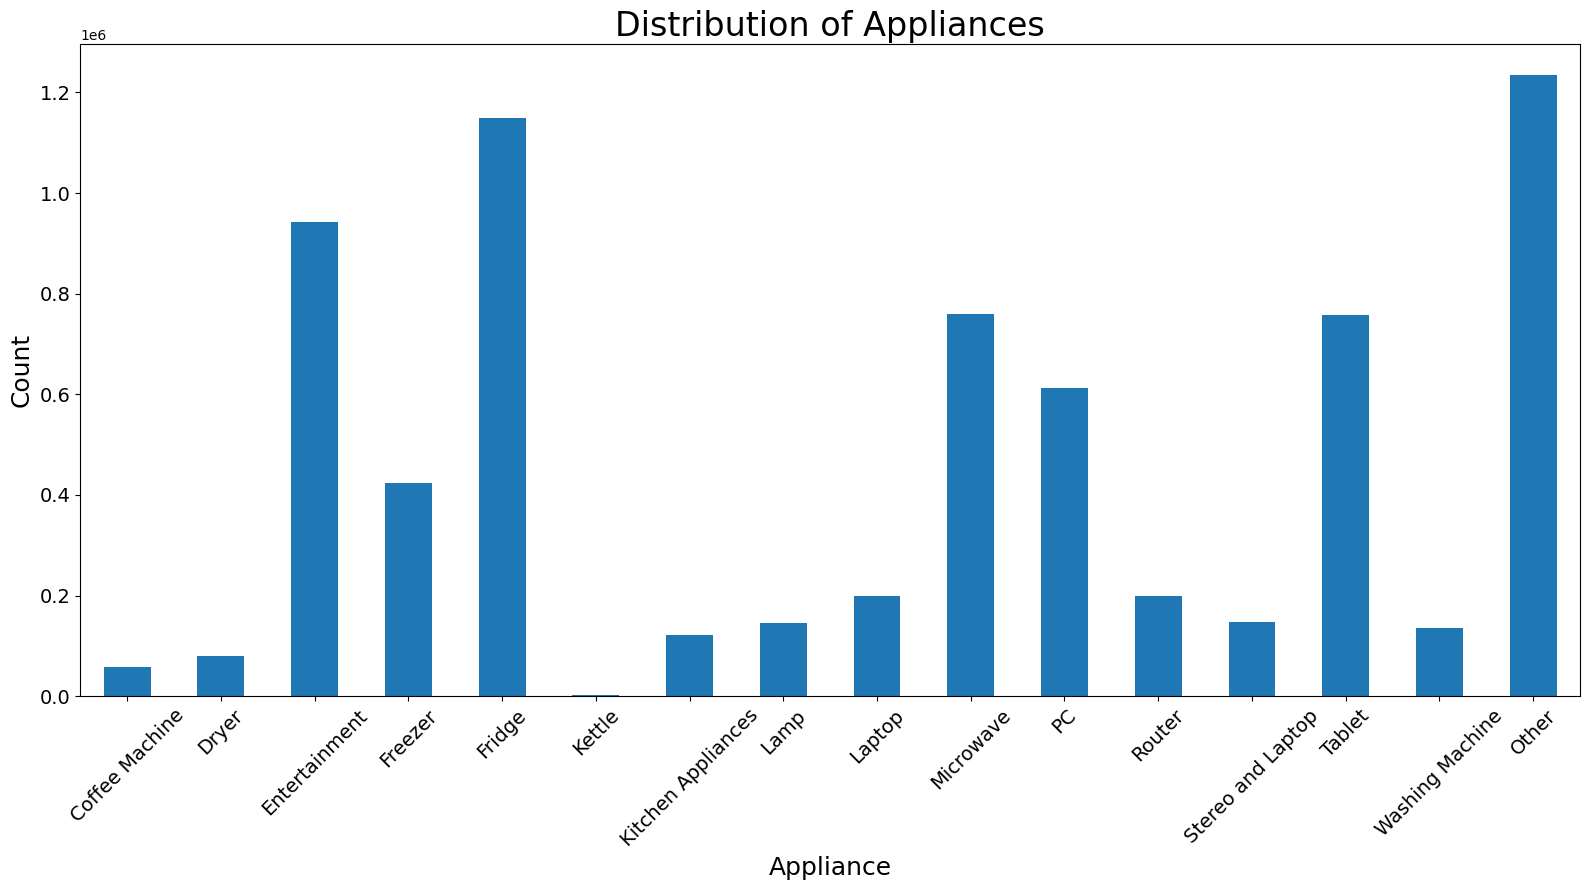

In [19]:
# Check the distribution of appliances
appliance_counts.plot(kind='bar', figsize=(16, 9))
plt.title('Distribution of Appliances', fontsize=24)
plt.xlabel('Appliance', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# Save figure
# plt.savefig('appliance_distribution.png', dpi=300, bbox_inches='tight')

plt.show()


In [20]:
import numpy as np
import pandas as pd

# Define custom functions with names
def p25(x): return np.percentile(x, 25)
def p75(x): return np.percentile(x, 75)
def duty_cycle(x): return (x > 0).mean()
def activation_count(x): return (x.diff() > 0).sum()
def active_steps(x): return (x > 0).sum()

# First compute standard metrics
base_metrics = combined_df[unique_appliances].agg(['min', 'max', 'mean', 'median', 'std']).T

# Now compute the others with .apply() column-wise
p25_vals = combined_df[unique_appliances].apply(p25)
p75_vals = combined_df[unique_appliances].apply(p75)
duty_vals = combined_df[unique_appliances].apply(duty_cycle)
activation_vals = combined_df[unique_appliances].apply(activation_count)
active_steps_vals = combined_df[unique_appliances].apply(active_steps)

# Combine all into a single DataFrame
data = pd.concat([
    base_metrics,
    p25_vals.rename("25%"),
    p75_vals.rename("75%"),
    duty_vals.rename("duty_cycle"),
    activation_vals.rename("activation_count"),
    active_steps_vals.rename("active_steps")
], axis=1)

# Optional: round for readability
data = data.round(3)

print(data)


                 min        max     mean   median      std     25%      75%  \
Coffee Machine   0.0   1459.221    3.748    0.000   60.132   0.000    0.000   
Dryer            0.0    855.252    4.619    0.000   59.342   0.000    0.000   
Freezer          0.0    901.022   28.647    0.000   69.614   0.000    2.009   
Fridge           0.0   1301.140   32.977    4.658   47.195   1.985   53.956   
Lamp             0.0    130.521    0.452    0.000    6.800   0.000    0.000   
Laptop           0.0     71.110    0.930    0.000    3.123   0.000    0.000   
Microwave        0.0   2637.667    6.512    4.135   74.926   0.000    5.511   
PC               0.0    174.455   16.117    0.000   20.877   0.000   27.528   
Router           0.0     21.471    3.217    0.000    7.350   0.000    0.000   
Tablet           0.0      9.007    2.498    1.783    2.325   0.000    4.545   
Washing Machine  0.0   2356.951    4.762    0.000   84.762   0.000    0.000   
Other            0.0  10651.465  419.312  181.199  8

## Plot the first 1000 points of each appliance

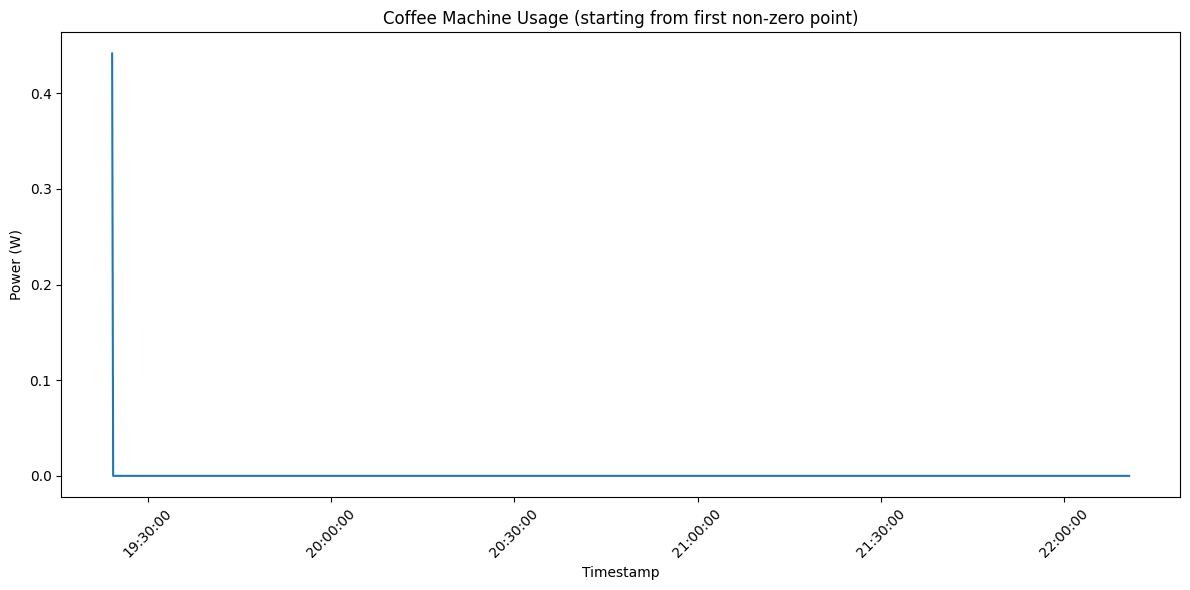

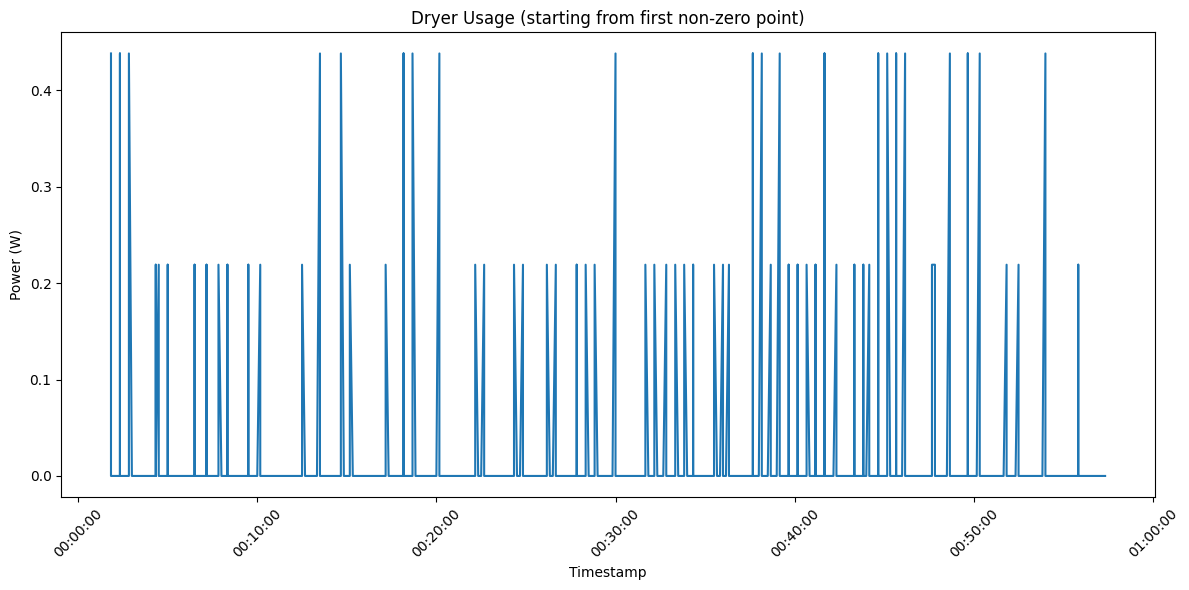

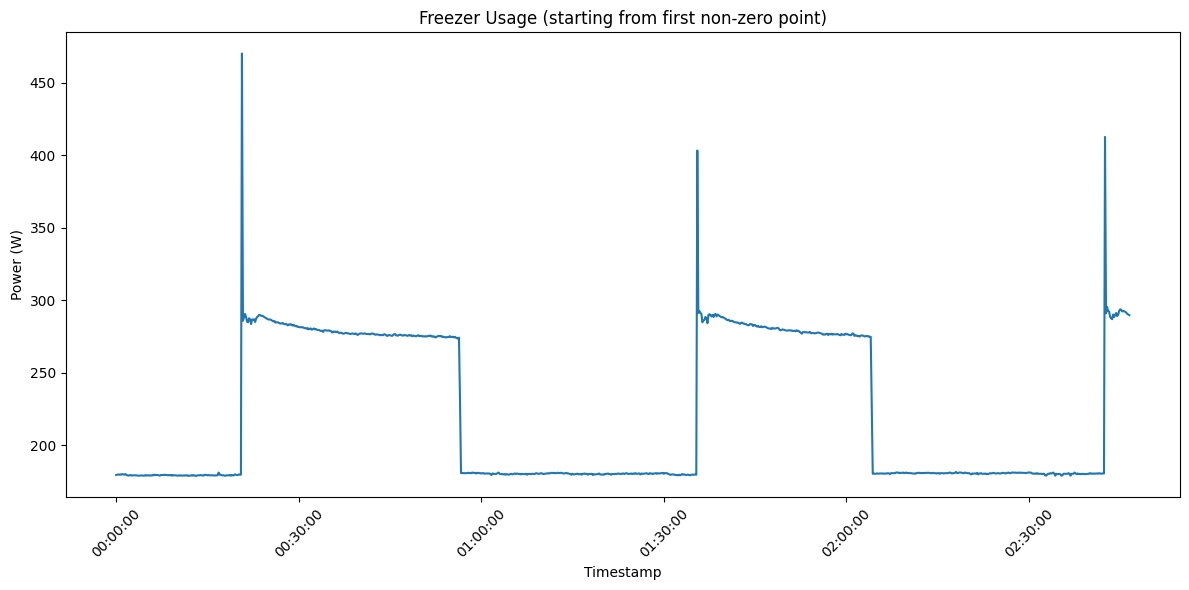

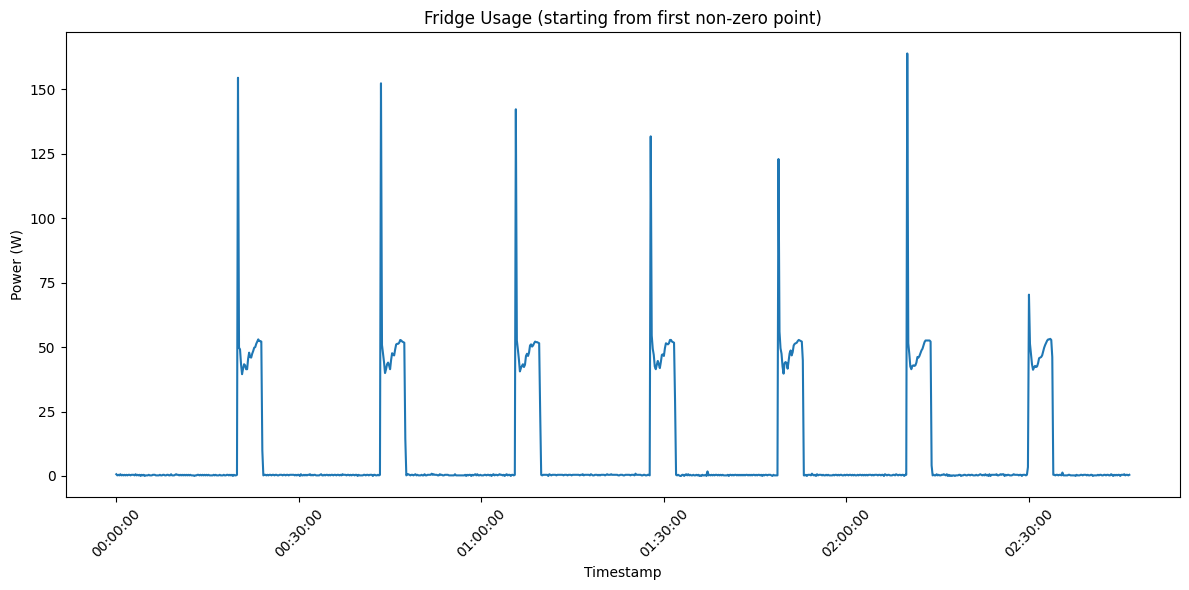

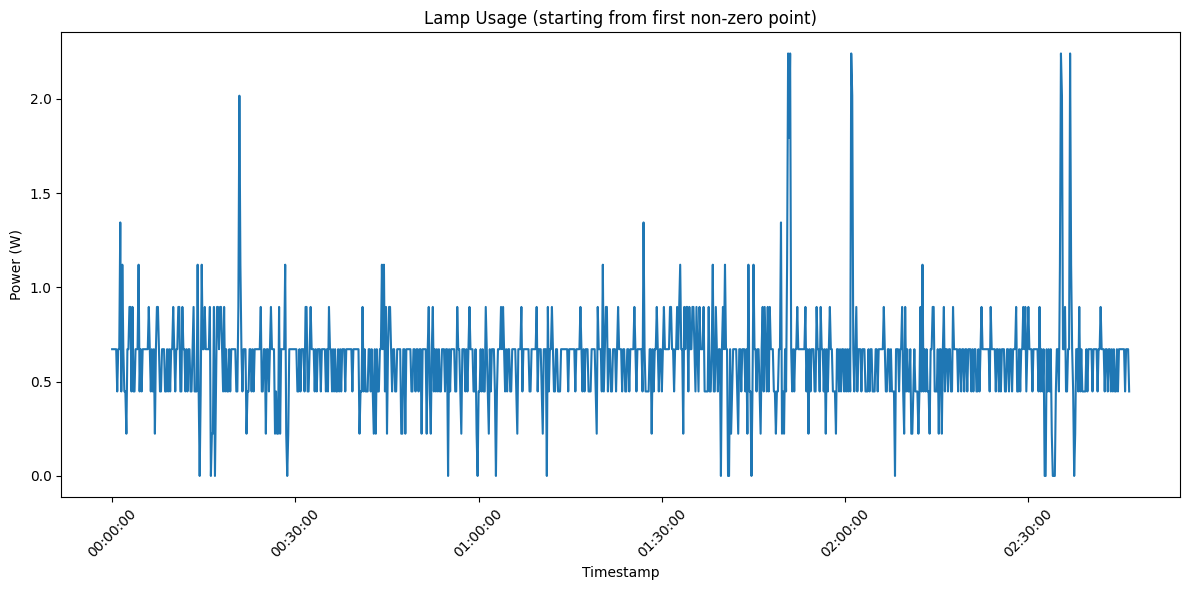

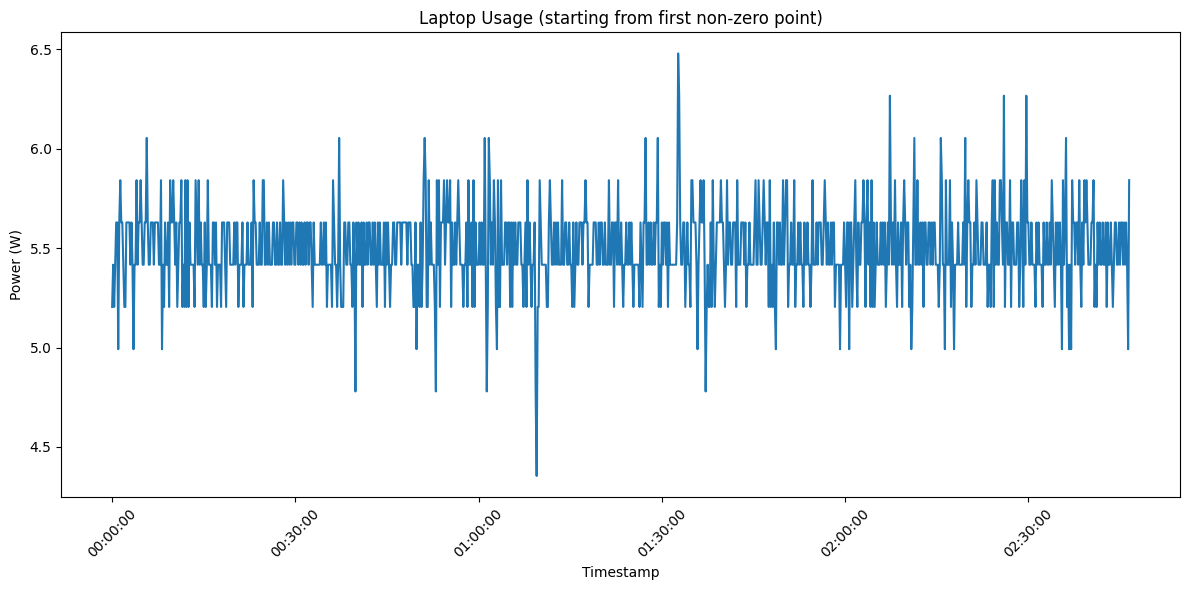

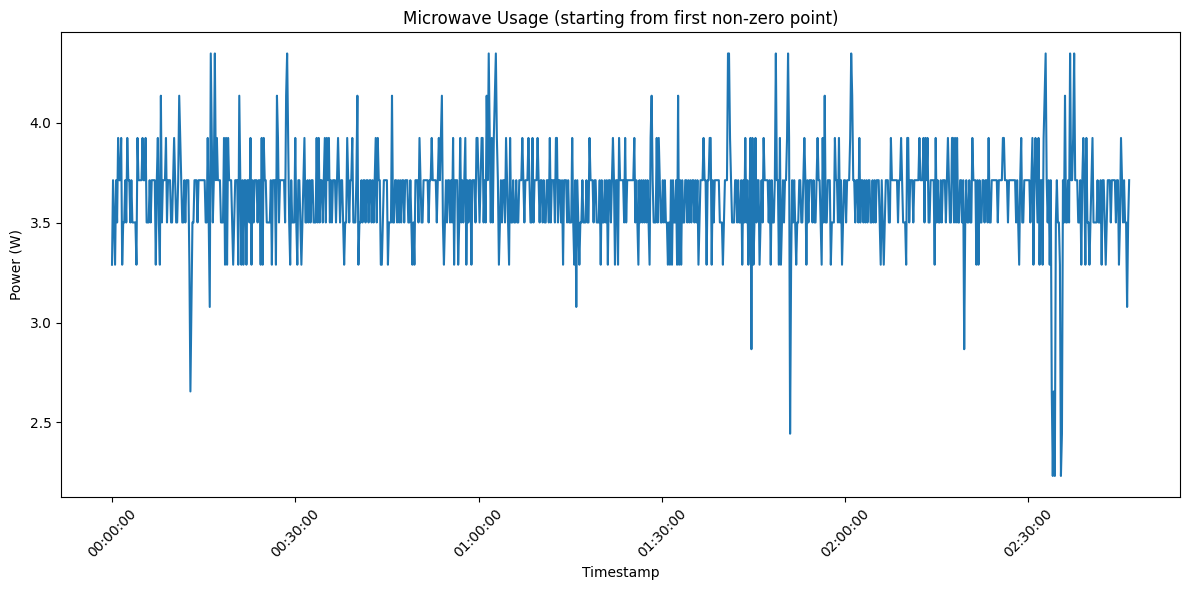

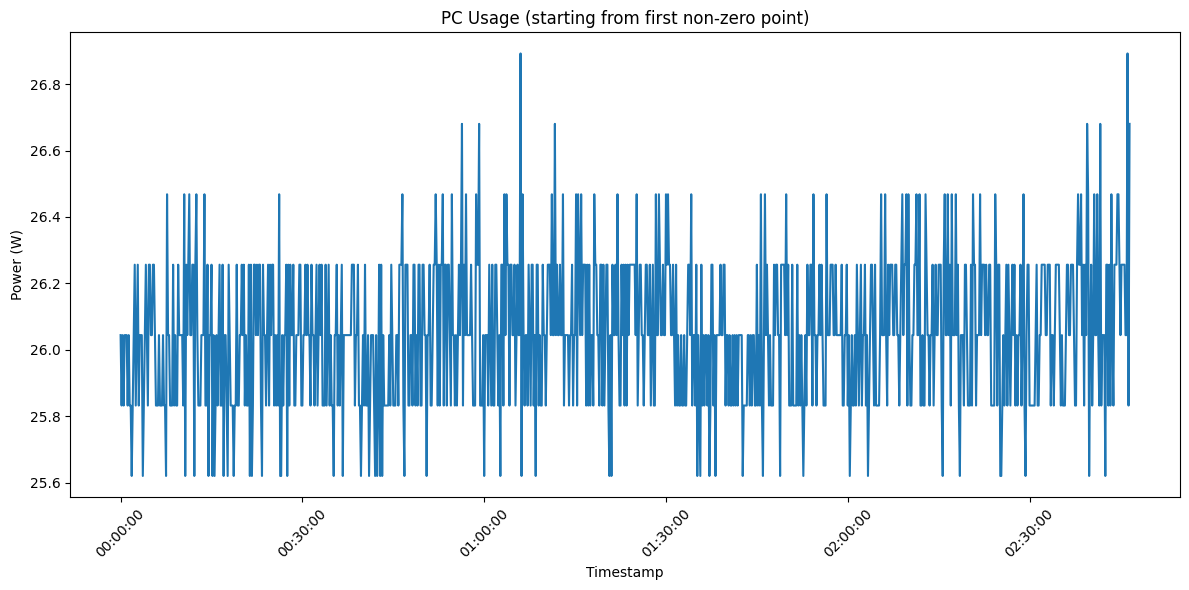

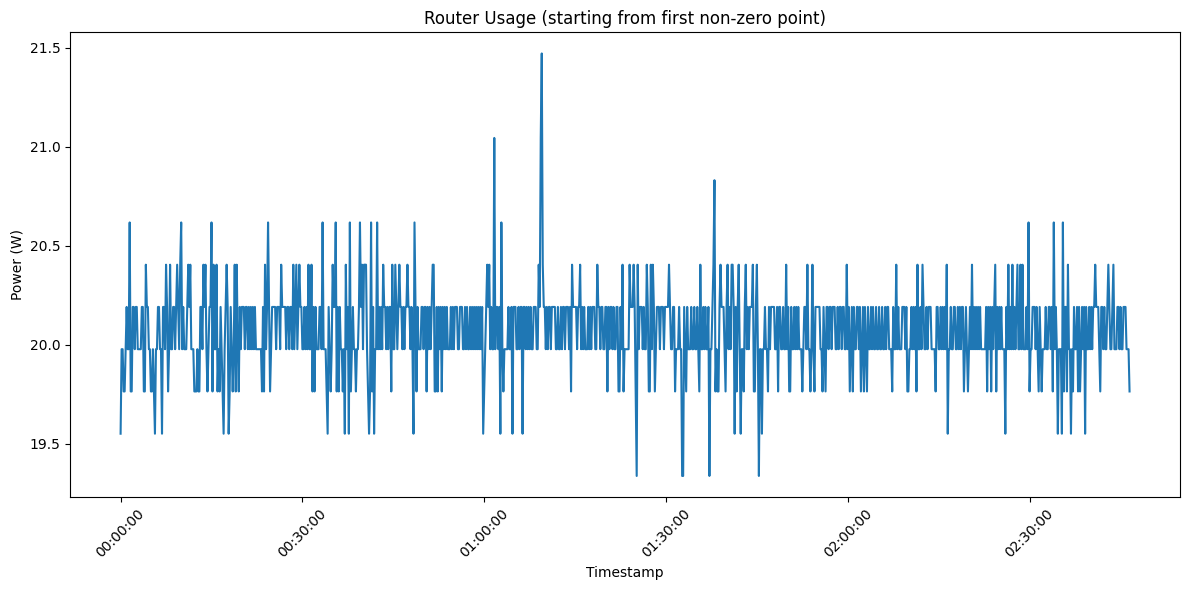

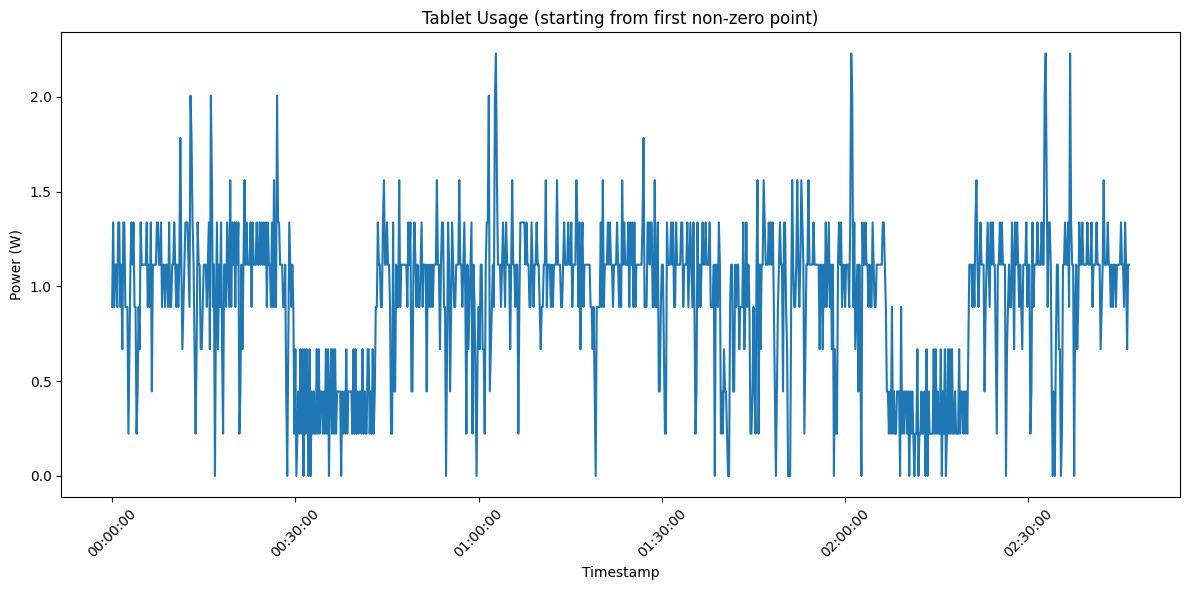

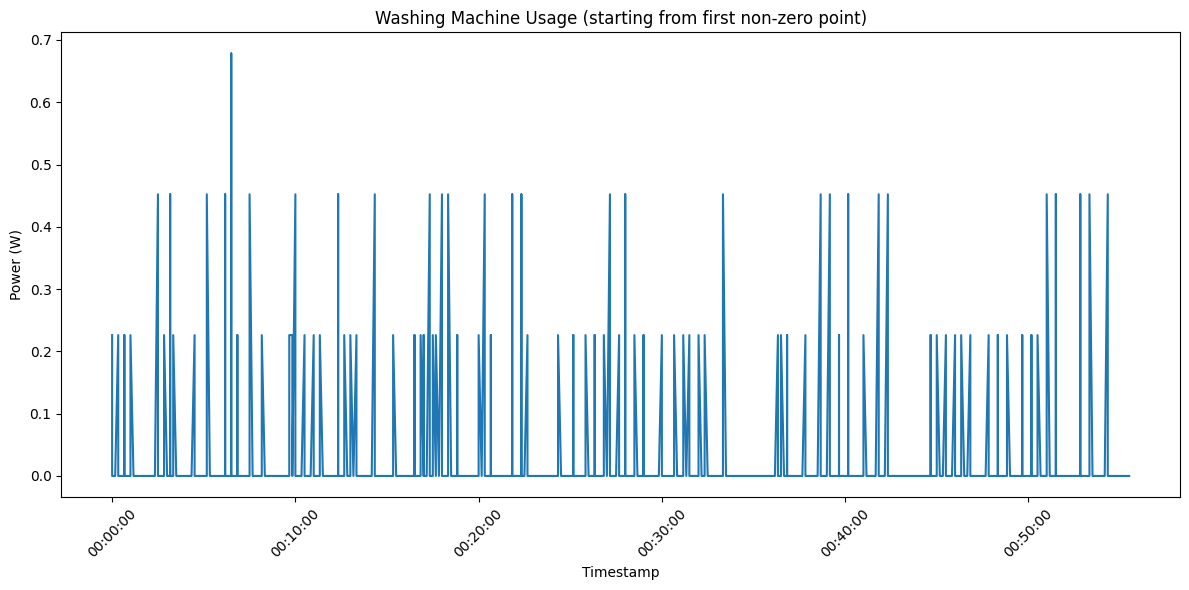

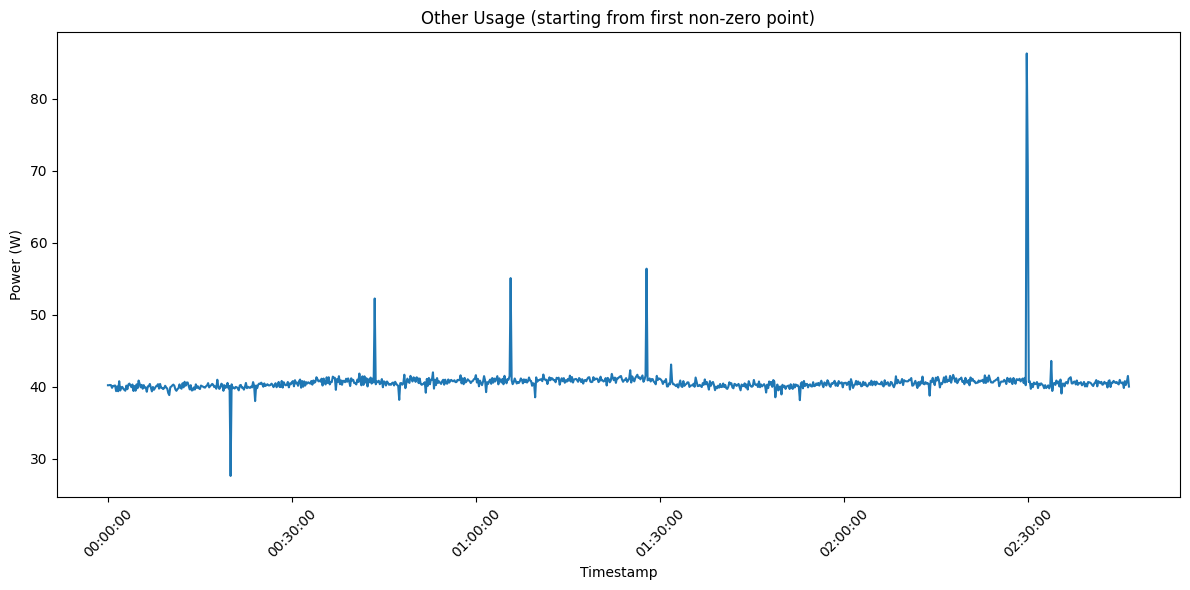

In [21]:
# Parse & clean timestamp
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'], errors='coerce')
df = combined_df.dropna(subset=['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

for appliance in unique_appliances:
    # Find the index of the first non-zero value
    non_zero_indices = df.index[df[appliance] > 0].tolist()

    if non_zero_indices:
        start_idx = non_zero_indices[0]
        end_idx = start_idx + 1000
        active_data = df.iloc[start_idx:end_idx][['timestamp', appliance]]

        plt.figure(figsize=(12, 6))
        plt.plot(active_data['timestamp'], active_data[appliance])
        plt.title(f'{appliance} Usage (starting from first non-zero point)')
        plt.xlabel('Timestamp')
        plt.ylabel('Power (W)')

        # Format X-axis ticks
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

## Save the dataframe to parquet file

In [22]:
# Save the cleaned DataFrame to a parquet file
path = os.path.join(data_path, training_dataset_file)
combined_df.to_parquet(path, index=False)

# Show file weight
print(f"File size: {os.path.getsize(path) / (1024 * 1024):.2f} MB")

File size: 58.29 MB
